In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.graphics.regressionplots as sgr
from analysis_tools import plot_trend

In [2]:
data = pd.read_csv("results.csv", index_col=0)
data['host'] = 'rapi'
more_data = pd.read_csv("tempresults.csv", index_col=0)
more_data['host'] = 'laptop'
data = pd.concat([data, more_data[6:]])
data.groupby(['host','pi_count'])['time'].describe()

count        mean        std         min         25%  \
host   pi_count                                                         
laptop 1           3.0   39.753146   0.485500   39.414432   39.475035   
rapi   1           3.0  768.969668  12.120681  761.601040  761.975124   
       2           3.0  391.394798  12.521109  376.936672  387.774849   
       3           3.0  324.482621   6.585242  317.476784  321.451113   
       4           3.0  300.761213   6.606650  293.250232  298.305390   
       5           3.0  159.577755   4.540377  154.572461  157.650913   

                        50%         75%         max  
host   pi_count                                      
laptop 1          39.535637   39.922503   40.309369  
rapi   1         762.349207  772.653983  782.958758  
       2         398.613025  398.623861  398.634696  
       3         325.425441  327.985540  330.545638  
       4         303.360547  304.516703  305.672859  
       5         160.729366  162.080402  163.431438

In [3]:
mod = smf.ols(formula='time ~ np.power(pi_count-2, 3):host', data=data)
res = mod.fit()
res.summary()

/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1390: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     13.48
Date:                Thu, 15 Mar 2018   Prob (F-statistic):           0.000445
Time:                        01:12:58   Log-Likelihood:                -113.98
No. Observations:                  18   AIC:                             234.0
Df Residuals:                      15   BIC:                             236.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                482.5330     46.278     10.427      0.000     383.895     581.171
np.power(pi_count - 2, 3):host[laptop]   442.7799     97.723      4.531      0.000     234.489     651.071
np.power(pi_count - 2, 3):host[rapi]     -13.3565      3.670     -3.639      0.002     -21.179      -5.534
==============================================================================
Omnibus:                        4.932   Durbin-Watson:                   0.744
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                3.462
Skew:                           1.074   Prob(JB):                        0.177
Kurtosis:                       2.992   Cond. No.                         33.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

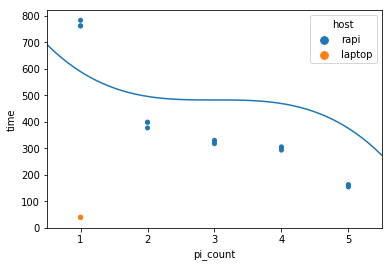

In [4]:
fig, ax = plt.subplots()
sns.stripplot(x='pi_count', y='time', hue='host', data=data, ax=ax)
ax.set_ylim(bottom=0)
plot_trend(res, 'pi_count', ax)
fig.savefig("pi_count_v_time.png")

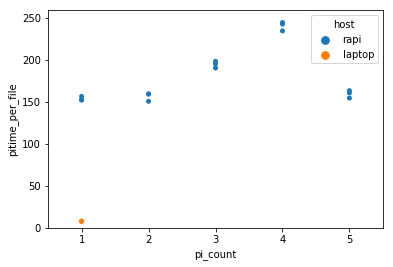

In [5]:
fig, ax = plt.subplots()
data['pitime_per_file'] = data['time']*data['pi_count']/data['file_count']
sns.stripplot(x='pi_count', y='pitime_per_file', hue='host', data=data, ax=ax)
ax.set_ylim(bottom=0)
fig.savefig("pitime_per_file_vs_count.png")

In [6]:
onejump = data['pi_count'].apply(lambda x: x in [1,2,5])

In [7]:
data.loc[onejump]['pitime_per_file'].mean()

119.47005927960079

In [8]:
curve_up = data['pi_count'].apply(lambda x: x in [2,3,4])
count_mod = smf.ols(formula='pitime_per_file ~ pi_count', data=data.loc[curve_up])
count_res = count_mod.fit()
count_res.summary()

/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1390: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        pitime_per_file   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     442.6
Date:                Thu, 15 Mar 2018   Prob (F-statistic):           1.38e-07
Time:                        01:12:59   Log-Likelihood:                -25.930
No. Observations:                   9   AIC:                             55.86
Df Residuals:                       7   BIC:                             56.25
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     71.2089      6.211     11.466      0.000      56.523      85.895
pi_count      42.0255      1.998     21.039      0.000      37.302      46.749
==============================================================================
Omnibus:                        2.952   Durbin-Watson:                   2.298
Prob(Omnibus):                  0.229   Jarque-Bera (JB):                0.994
Skew:                          -0.260   Prob(JB):                        0.608
Kurtosis:                       1.457   Cond. No.                         13.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""